# Experiment Analysis

## Loading the CSV file

In [11]:
import pandas as pd

df = pd.read_csv("../data/final_experiment_dataset.csv")
final_experiment_df = df.copy()
final_experiment_df.head(5)

,client_id,Variation,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,merged_session_id,converted,first_time,last_time,total_duration_sec,n_events,n_attempts,n_errors,any_anomaly
0,9988021,Test,5.0,64.0,79.0,U,2.0,189023.86,1.0,4.0,1,False,2017-04-12 16:57:27,2017-04-17 15:27:07,426580.0,15,1,2,False
1,8320017,Test,22.0,274.0,34.5,M,2.0,36001.90,5.0,8.0,1,True,2017-04-05 13:08:06,2017-04-05 13:10:05,119.0,5,1,0,False
2,4033851,Control,12.0,149.0,63.5,M,2.0,142642.26,5.0,8.0,1,True,2017-04-05 12:04:00,2017-04-05 12:29:03,1503.0,15,1,3,True
3,1982004,Test,6.0,80.0,44.5,U,2.0,30231.76,1.0,4.0,1,True,2017-04-17 11:59:42,2017-04-17 12:02:42,180.0,5,1,0,False
4,9294070,Control,5.0,70.0,29.0,U,2.0,34254.54,0.0,3.0,1,False,2017-04-17 11:16:13,2017-04-17 11:16:28,15.0,2,1,0,False


In [12]:
final_experiment_df.shape

(56252, 19)

## Controlling for bias between groups

In [13]:
final_experiment_df["Variation"].value_counts()

Variation
Test       29970
Control    26282
Name: count, dtype: int64

In [14]:
final_experiment_df.groupby("Variation")[[
    "clnt_age",
    "clnt_tenure_yr",
    "num_accts",
    "calls_6_mnth",
    "logons_6_mnth"
]].mean()


,clnt_age,clnt_tenure_yr,num_accts,calls_6_mnth,logons_6_mnth
Variation,,,,,
Control,47.819667,12.151168,2.266875,3.200099,6.236664
Test,47.652886,12.092659,2.257424,3.139206,6.178545


In [15]:
# Baseline demographics and engagement metrics are well balanced between the control and test groups, indicating successful random assignment and low risk of selection bias.

In [16]:
from scipy.stats import ttest_ind

ctrl = final_experiment_df[final_experiment_df["Variation"] == "Control"]["clnt_age"]
test = final_experiment_df[final_experiment_df["Variation"] == "Test"]["clnt_age"]

ttest_ind(ctrl, test, nan_policy="omit")


TtestResult(statistic=np.float64(1.2676830202856066), pvalue=np.float64(0.20491641833028748), df=np.float64(56250.0))

p-value ≈ 0.205
This is well above common thresholds (0.05 or 0.01).

Interpretation
We fail to reject the null hypothesis that the mean age is the same in Control and Test.

What that means here:
There is no statistically significant age difference between the two groups.
That supports good randomization and low selection bias.

## KPIs

### Client level diagnostics

- KPI #1: Conversion Rate: We define "Coversion Rate" as the ratio between successful completion of sessions (from start to confirm) compared to the total amount ot sessions initiated. 

In [17]:
# for that we need to group by "Variation" and check for "converted", calculating the mean(), and hsowing it by percentage
conversion_by_group = final_experiment_df.groupby("Variation")["converted"].mean()

(conversion_by_group * 100).round(2)

Variation
Control    53.88
Test       63.74
Name: converted, dtype: float64

In [18]:
# now let's test for the statistical significance of our result
import numpy as np

conv_table = (
    final_experiment_df
    .groupby("Variation")["converted"]
    .agg(["sum", "count"])
)

conv_table

x_test  = conv_table.loc["Test", "sum"]
n_test  = conv_table.loc["Test", "count"]

x_ctrl  = conv_table.loc["Control", "sum"]
n_ctrl  = conv_table.loc["Control", "count"]

from statsmodels.stats.proportion import proportions_ztest

stat, pval = proportions_ztest(
    count=np.array([x_test, x_ctrl]),
    nobs=np.array([n_test, n_ctrl]),
    alternative="two-sided"
)

stat, pval


(np.float64(23.73233566793729), np.float64(1.6724270218096497e-124))

In [19]:
# Our null hypothesis is that the difference in the conversion rate in not significant. 
# after running our statistical test above, we can see that we get an incredibly small p-value, much lower than 0.05.
# hence our result is significant.

- KPI #2: Average Total Time to Completion: What is average time duration that takes a converting customer to complete a session.

In [21]:
converters_df = final_experiment_df[final_experiment_df["converted"]].copy()
converters_df

,client_id,Variation,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,merged_session_id,converted,first_time,last_time,total_duration_sec,n_events,n_attempts,n_errors,any_anomaly
1,8320017,Test,22.0,274.0,34.5,M,2.0,36001.90,5.0,8.0,1,True,2017-04-05 13:08:06,2017-04-05 13:10:05,119.0,5,1,0,False
2,4033851,Control,12.0,149.0,63.5,M,2.0,142642.26,5.0,8.0,1,True,2017-04-05 12:04:00,2017-04-05 12:29:03,1503.0,15,1,3,True
3,1982004,Test,6.0,80.0,44.5,U,2.0,30231.76,1.0,4.0,1,True,2017-04-17 11:59:42,2017-04-17 12:02:42,180.0,5,1,0,False
6,3170143,Test,21.0,254.0,53.5,F,2.0,192109.59,6.0,9.0,1,True,2017-04-04 18:38:02,2017-04-04 18:41:44,222.0,5,1,0,False
10,5887227,Test,6.0,79.0,32.5,U,2.0,60274.39,1.0,4.0,1,True,2017-04-05 14:45:14,2017-04-05 14:52:34,440.0,7,1,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56243,8692087,Test,14.0,179.0,60.5,F,3.0,85826.90,4.0,7.0,2,True,2017-03-29 17:16:08,2017-03-29 17:29:18,790.0,15,1,3,True
56246,5305116,Control,18.0,226.0,63.5,F,3.0,89726.65,2.0,5.0,2,True,2017-04-20 09:25:23,2017-04-20 09:30:11,288.0,5,1,0,False
56247,393005,Control,15.0,191.0,52.5,M,2.0,60344.67,1.0,4.0,1,True,2017-03-29 15:25:20,2017-03-29 15:46:16,1256.0,11,1,3,False
56250,5230357,Test,23.0,278.0,30.5,M,2.0,61349.70,0.0,3.0,1,True,2017-04-19 11:23:05,2017-04-19 11:24:46,101.0,5,1,0,False


In [26]:
converters_df["total_duration_sec"].max()

8373949.0

In [71]:
# by checking the ax value of "total_duration_sec" we understand that there are some outliers in our groups that are driving the avergages to crazy levels. Therefore we need to find them and exclude them,
q1 = converters_df["total_duration_sec"].quantile(0.25)
q3 = converters_df["total_duration_sec"].quantile(0.75)
iqr = q3 - q1

lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

q1, q3, iqr, lower, upper


(np.float64(167.0),
 np.float64(697.0),
 np.float64(530.0),
 np.float64(-628.0),
 np.float64(1492.0))

In [72]:
# therefore we take as the absolute uppoer limit of session duration the 1492 seconds.
outliers = converters_df[
    (converters_df["total_duration_sec"] < lower) |
    (converters_df["total_duration_sec"] > upper)
]

outliers.shape


(5679, 19)

In [73]:
# and we will remove those rows
conv_no_outliers_df = converters_df[
    (converters_df["total_duration_sec"] >= lower) &
    (converters_df["total_duration_sec"] <= upper)
].copy()

conv_no_outliers_df.shape

(27587, 19)

In [74]:
avg_time_by_group = conv_no_outliers_df.groupby("Variation")["total_duration_sec"].mean()
avg_time_by_group

Variation
Control    341.325076
Test       313.267769
Name: total_duration_sec, dtype: float64

In [50]:
# i will convert that to minutes
(avg_time_by_group / 60).round(2)

Variation
Control    5.69
Test       5.22
Name: total_duration_sec, dtype: float64

In [53]:
# now let's test for the statistical significance of our result
test_time = conv_no_outliers[conv_no_outliers["Variation"] == "Test"]["total_duration_sec"].values
ctrl_time = conv_no_outliers[conv_no_outliers["Variation"] == "Control"]["total_duration_sec"].values

import numpy as np

n_boot = 10000
boot_diffs = []

for _ in range(n_boot):
    boot_test = np.random.choice(test_time, size=len(test_time), replace=True)
    boot_ctrl = np.random.choice(ctrl_time, size=len(ctrl_time), replace=True)
    boot_diffs.append(boot_test.mean() - boot_ctrl.mean())

boot_diffs = np.array(boot_diffs)

ci_low, ci_high = np.percentile(boot_diffs, [2.5, 97.5])
ci_low, ci_high


(np.float64(-34.28716815995615), np.float64(-21.891496316520325))

In [54]:
# the value of "0" is not between ci_low and ci_high, which makes our result statistically significant.

In [56]:
# checking our interpretation with the p-value
p_value = np.mean(np.abs(boot_diffs) <= 0)
p_value


np.float64(0.0)

- KPI #3: STD of Total Time to Completion: A smooth UI reduced variability.

In [61]:
std_per_group = conv_no_outliers_df.groupby("Variation")["total_duration_sec"].std()

(std_per_group / 60).round(2)

Variation
Control    4.31
Test       4.47
Name: total_duration_sec, dtype: float64

In [ ]:
# our null hypothesis is that there is NO significant difference in standard deviation between the two groups

In [62]:
from scipy.stats import levene

test_time = conv_no_outliers[conv_no_outliers["Variation"] == "Test"]["total_duration_sec"]
ctrl_time = conv_no_outliers[conv_no_outliers["Variation"] == "Control"]["total_duration_sec"]

stat, pval = levene(test_time, ctrl_time)
stat, pval


(np.float64(2.7923507135371954), np.float64(0.0947265372306685))

In [63]:
# with a p-value > 0.05, we fail to reject th null hypothesis. Therefore, we cannot say that the standard deviation in the test group is bigger with statistical significance. We cannot rule out random variation.

- KPI #4: Average number of events (steps) per client: more steps indicate confusion with the UI.

In [68]:
final_experiment_df["n_events"].nunique()

55

In [65]:
# let's explore for outliers
q1_a = final_experiment_df["n_events"].quantile(0.25)
q3_a = final_experiment_df["n_events"].quantile(0.75)
iqr_a = q3_a - q1_a

lower_a = q1_a - 1.5 * iqr_a
upper_a = q3_a + 1.5 * iqr_a

lower_a, upper_a

(np.float64(-0.5), np.float64(11.5))

In [69]:
# therefore we take as the absolute uppoer limit of session duration the 11.5 seconds.
outliers_events = final_experiment_df[
    (final_experiment_df["n_events"] < lower_a) |
    (final_experiment_df["n_events"] > upper_a)
]

outliers_events.shape

(3080, 19)

In [76]:
# and we will remove those rows
attempts_per_client_df = final_experiment_df[
    (final_experiment_df["total_duration_sec"] >= lower) &
    (final_experiment_df["total_duration_sec"] <= upper)
].copy()

attempts_per_client_df.shape

(46463, 19)

In [78]:
attempts_per_client = attempts_per_client_df.groupby("Variation")["n_events"].mean()
attempts_per_client

Variation
Control    4.613899
Test       5.052548
Name: n_events, dtype: float64

In [82]:
# statistical test to undersatnd significance
import numpy as np

test_attempts = final_experiment_df[
    final_experiment_df["Variation"] == "Test"
]["n_events"].values

ctrl_attempts = final_experiment_df[
    final_experiment_df["Variation"] == "Control"
]["n_events"].values

n_boot = 10000
boot_diffs_2 = []

for _ in range(n_boot):
    boot_test = np.random.choice(test_attempts, size=len(test_attempts), replace=True)
    boot_ctrl = np.random.choice(ctrl_attempts, size=len(ctrl_attempts), replace=True)
    boot_diffs_2.append(boot_test.mean() - boot_ctrl.mean())

boot_diffs_2 = np.array(boot_diffs_2)

ci_low, ci_high = np.percentile(boot_diffs_2, [2.5, 97.5])
ci_low, ci_high


(np.float64(0.4902132960142243), np.float64(0.6062527080767707))

In [84]:
p_value = np.mean(np.abs(boot_diffs_2) <= 0)
print(f"p-value = {p_value:.2e}")

p-value = 0.00e+00


In [85]:
# since "0" is not part of our ci_low and ci_high, then the difference in n_events is statistically significant.

### Step-level diagnostics

- KPI #5: Time per step: useful to identify bootlenecks and moments where the user struggles with the UI.

- KPI #6: Drop-off rate per step: Where do users mostly abandon?

- KPI #7: Error rate per step: how often users move backward or hit errors.

In [3]:
import pandas as pd
import numpy as np
df = pd.read_csv("../data/final_per_step_dataset.csv")
final_per_step_df = df.copy()
final_per_step_df.head(5)

,client_id,visitor_id,visit_id,process_step,date_time,process_step_num,step_diff,step_anomaly,next_time,duration_seconds,...,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,is_error,is_dropoff
0,555,402506806_56087378777,637149525_38041617439_716659,start,2017-04-15 12:57:56,0,NaN,False,2017-04-15 12:58:03,7.0,...,3.0,46.0,29.5,U,2.0,25454.66,2.0,6.0,False,False
1,555,402506806_56087378777,637149525_38041617439_716659,step_1,2017-04-15 12:58:03,1,1.0,False,2017-04-15 12:58:35,32.0,...,3.0,46.0,29.5,U,2.0,25454.66,2.0,6.0,False,False
2,555,402506806_56087378777,637149525_38041617439_716659,step_2,2017-04-15 12:58:35,2,1.0,False,2017-04-15 13:00:14,99.0,...,3.0,46.0,29.5,U,2.0,25454.66,2.0,6.0,False,False
3,555,402506806_56087378777,637149525_38041617439_716659,step_3,2017-04-15 13:00:14,3,1.0,False,2017-04-15 13:00:34,20.0,...,3.0,46.0,29.5,U,2.0,25454.66,2.0,6.0,False,False
4,555,402506806_56087378777,637149525_38041617439_716659,confirm,2017-04-15 13:00:34,4,1.0,False,NaN,NaN,...,3.0,46.0,29.5,U,2.0,25454.66,2.0,6.0,False,False


In [4]:
final_per_step_df.shape

(317123, 25)

In [ ]:
# How often users move backward or hit errors

In [5]:
error_events_df = final_per_step_df.copy(deep=True)

In [6]:
error_events_df["is_error"].unique()

array([False,  True])

In [16]:
# Error rate per client
error_rate_per_client_df = (
    error_events_df
    .groupby(["client_id", "Variation"], as_index=False)
    .agg(error_rate=("is_error", "mean"))
)
(error_rate_per_client_df * 100).round(2)

,client_id,Variation,error_rate
0,55500,TestTestTestTestTestTestTestTestTestTestTestTe...,0.00
1,64700,TestTestTestTestTestTestTestTestTestTestTestTe...,0.00
2,93400,TestTestTestTestTestTestTestTestTestTestTestTe...,0.00
3,102800,ControlControlControlControlControlControlCont...,22.22
4,110400,ControlControlControlControlControlControlCont...,0.00
...,...,...,...
50482,999915000,TestTestTestTestTestTestTestTestTestTestTestTe...,33.33
50483,999940000,TestTestTestTestTestTestTestTestTestTestTestTe...,0.00
50484,999962600,TestTestTestTestTestTestTestTestTestTestTestTe...,0.00
50485,999972900,TestTestTestTestTestTestTestTestTestTestTestTe...,9.09


In [15]:
#Comparing by Variation
avg_error_rate_by_variation = (
    error_rate_per_client_df
    .groupby("Variation")["error_rate"]
    .mean()
)
(avg_error_rate_by_variation * 100).round(2)

Variation
Control    5.66
Test       7.09
Name: error_rate, dtype: float64

In [11]:
# significance test
import numpy as np

test_errors = error_rate_per_client_df.loc[
    error_rate_per_client_df["Variation"] == "Test", "error_rate"
].values

ctrl_errors = error_rate_per_client_df.loc[
    error_rate_per_client_df["Variation"] == "Control", "error_rate"
].values

n_boot = 10000
boot_diffs_7 = []

for _ in range(n_boot):
    boot_test = np.random.choice(test_errors, size=len(test_errors), replace=True)
    boot_ctrl = np.random.choice(ctrl_errors, size=len(ctrl_errors), replace=True)
    boot_diffs_7.append(boot_test.mean() - boot_ctrl.mean())

boot_diffs_7 = np.array(boot_diffs_7)

ci_low, ci_high = np.percentile(boot_diffs_7, [2.5, 97.5])
(ci_low, ci_high)

(np.float64(0.012591298619990445), np.float64(0.016055659947072306))

In [13]:
p_value = np.mean(np.abs(boot_diffs_7) <= 0)
print(f"p-value = {p_value:.2e}")

p-value = 0.00e+00


The test version shows a statistically significant increase in user error rate compared to the control group (1.3–1.6= -0.3 Per person, p < 0.001), indicating increased user friction.

In [19]:
error_per_step = final_per_step_df.groupby(["Variation", "process_step"])["is_error"].mean()
error_per_step

Variation  process_step
Control    confirm         0.089330
           start           0.000000
           step_1          0.109301
           step_2          0.097966
           step_3          0.214181
Test       confirm         0.024420
           start           0.000000
           step_1          0.186981
           step_2          0.165760
           step_3          0.201437
Name: is_error, dtype: float64

In [21]:
VANGUARD_PALETTE = {
    "red":      "#96151D",  # anchor
    "charcoal": "#222222",
    "slate":    "#4B5563",
    "steel":    "#64748B",
    "blue":     "#1F4E79",
    "teal":     "#0F766E",
    "gold":     "#B08900",
    "light":    "#E5E7EB",
}

# handy ordered list for seaborn/matplotlib
VANGUARD_COLORS = [
    VANGUARD_PALETTE["red"],
    VANGUARD_PALETTE["blue"],
    VANGUARD_PALETTE["teal"],
    VANGUARD_PALETTE["gold"],
    VANGUARD_PALETTE["slate"],
    VANGUARD_PALETTE["steel"],
    VANGUARD_PALETTE["charcoal"],
    VANGUARD_PALETTE["light"],
]

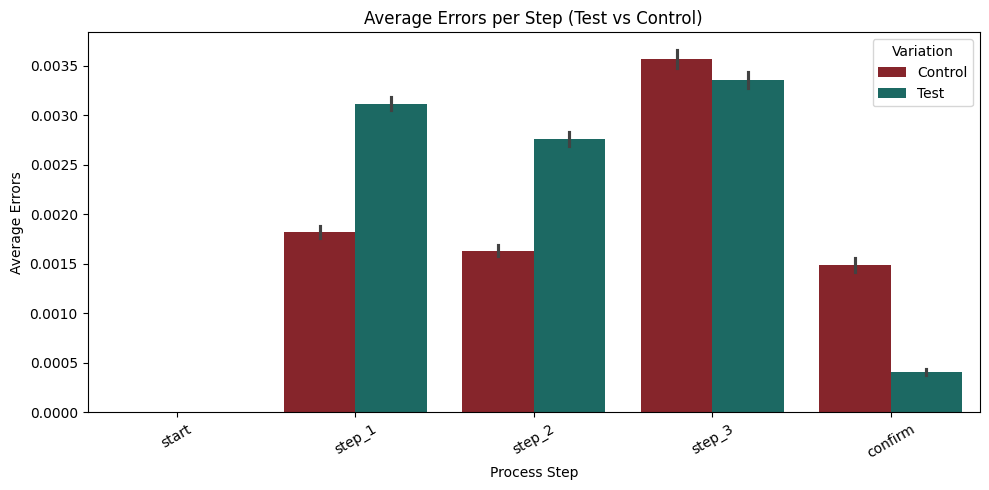

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.barplot(
    data=final_per_step_df,
    x="process_step",
    y=final_per_step_df["is_error"] / 60,
    hue="Variation",
    hue_order=["Control", "Test"],   # key line
    palette=[VANGUARD_PALETTE["red"], VANGUARD_PALETTE["teal"]]
)

plt.title("Average Errors per Step (Test vs Control)")
plt.xlabel("Process Step")
plt.ylabel("Average Errors")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

- KPI #8: Anomaly rate: irregular step jumps or session fragmentation, indicate improper use of the UI.